In [1]:
from itertools import product

import zarr
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
from distributed import Client
from numcodecs import blosc
from skimage.restoration import denoise_nl_means, estimate_sigma

In [2]:
client = Client()

In [3]:
codec = blosc.Blosc(cname="zstd", clevel=9, shuffle=blosc.Blosc.SHUFFLE)

In [4]:
image_path = "/root/capsule/data/exaSPIM_706301_training_blocks/block_001/block_001.zarr"
arr = da.from_zarr(image_path, component='0').squeeze()
slice_num = arr.shape[0] // 2
s = arr[slice_num].compute()

In [5]:
def plot_slice(s, title=None):
    plt.figure(figsize=(8,8))
    plt.imshow(s, cmap='gray', vmin=0, vmax=100)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

In [6]:
sigma = estimate_sigma(s, channel_axis=None)
print(sigma)

4.829980333080396


In [ ]:
patch_sizes = [7, 9, 11]
patch_distances = [11, 13, 15]
h_values = [i * sigma for i in np.arange(0.6, 1.0, 0.2)]
sigmas = [sigma]

params = list(product(patch_sizes, patch_distances, h_values, sigmas))
#print(params)

Compression ratio: 4.55880805700597


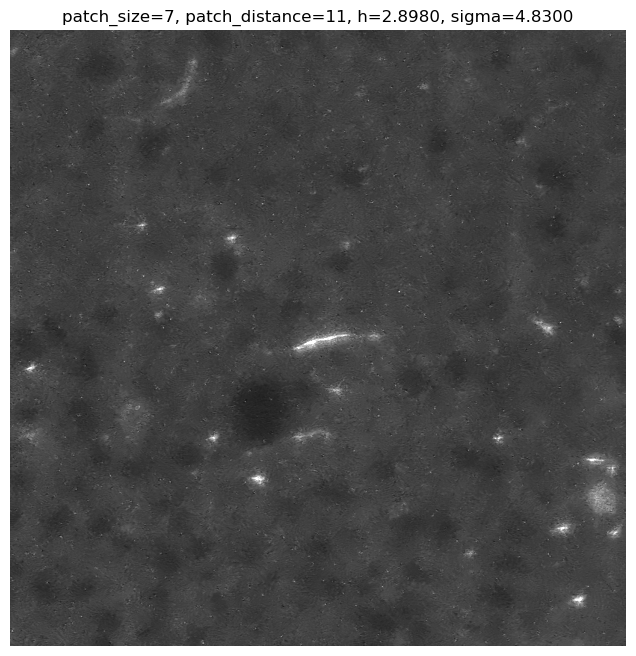

Compression ratio: 5.914084201205291


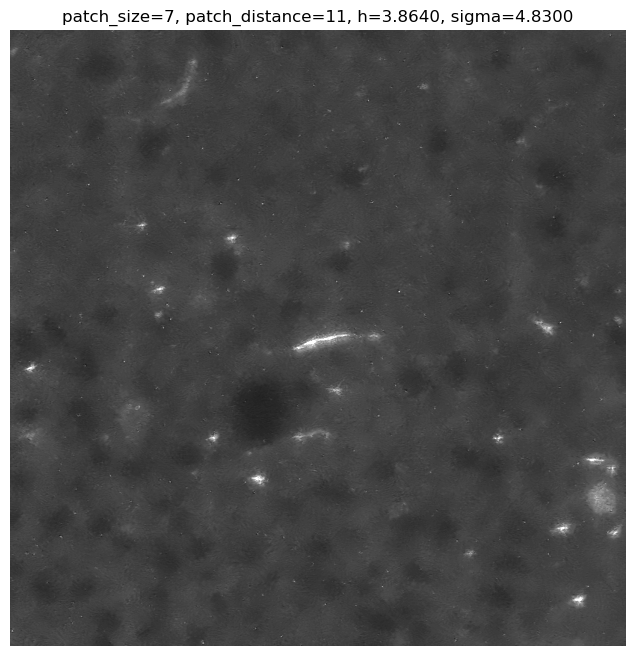

Compression ratio: 4.659064300202389


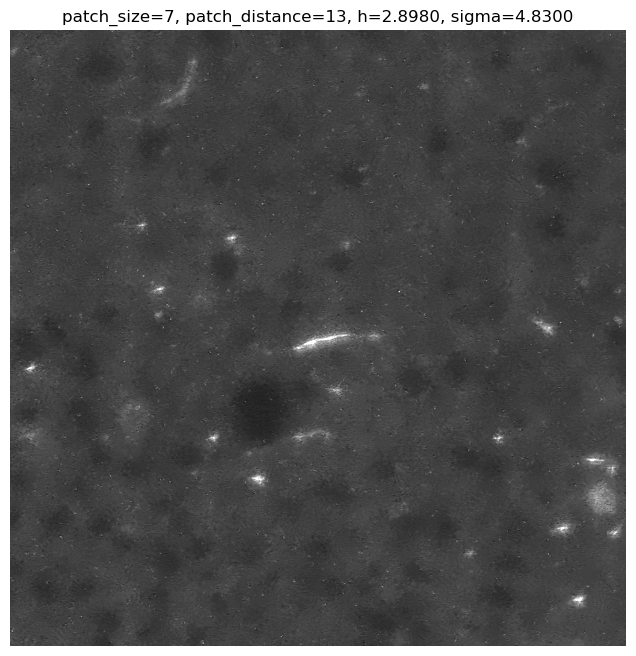

Compression ratio: 6.0604848614454525


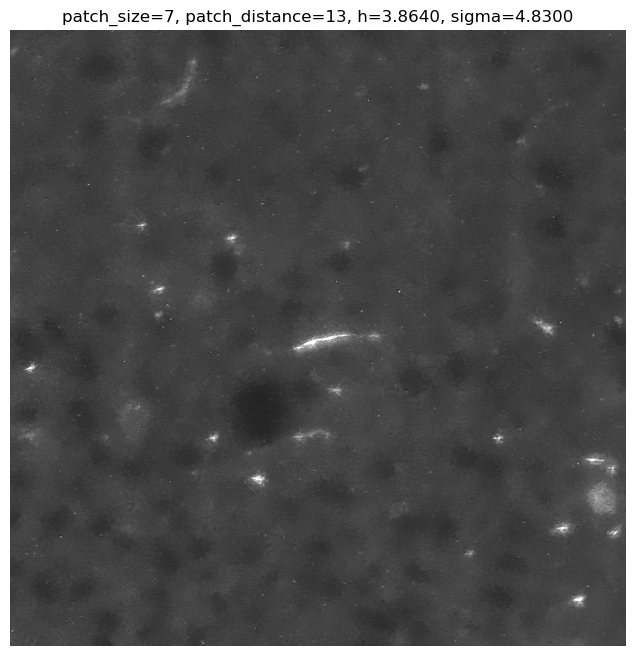

Compression ratio: 4.758219642739647


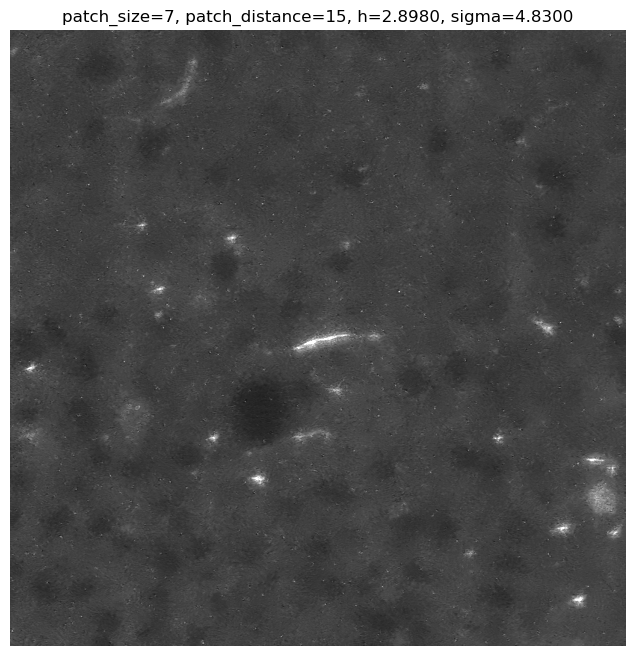

Compression ratio: 6.162149455819092


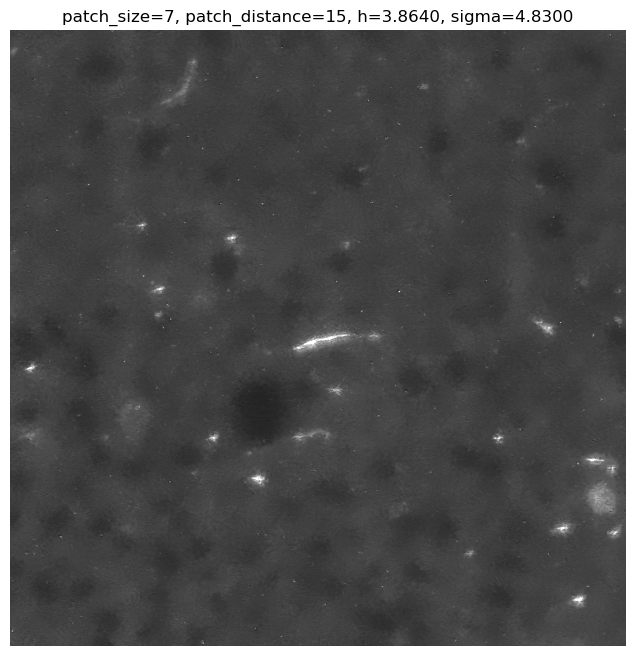

Compression ratio: 4.468500103341224


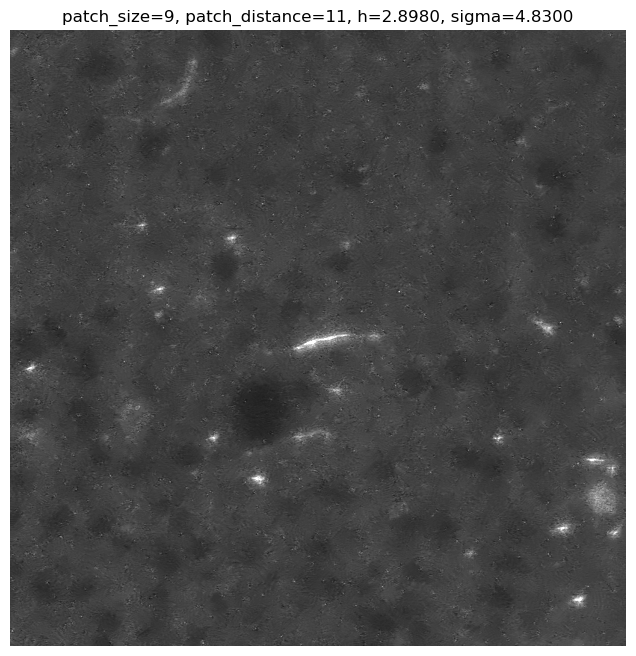

Compression ratio: 6.5041078046738106


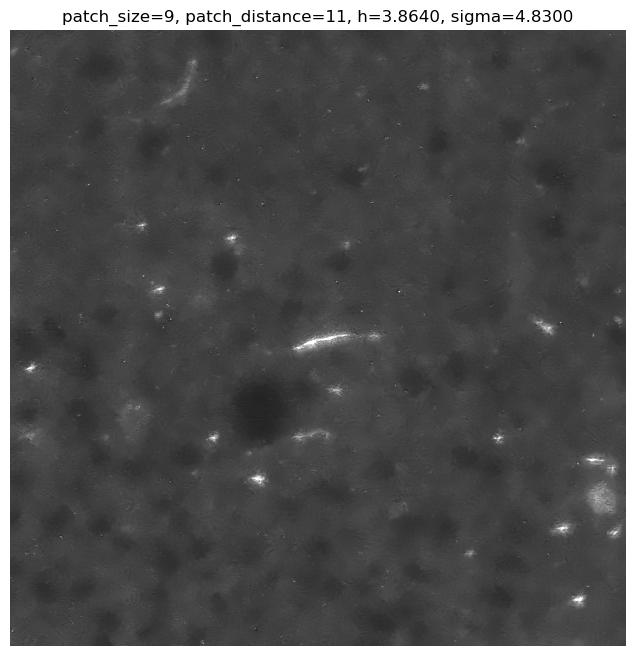

Compression ratio: 4.61146648078475


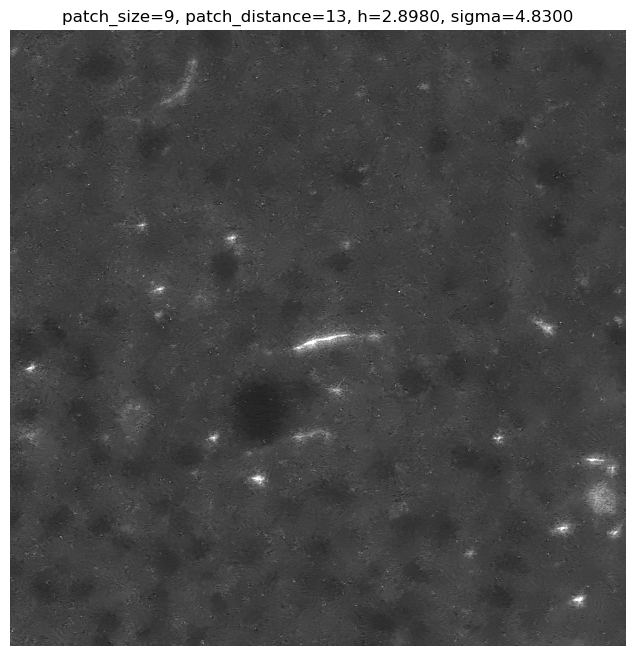

Compression ratio: 6.7772273228175965


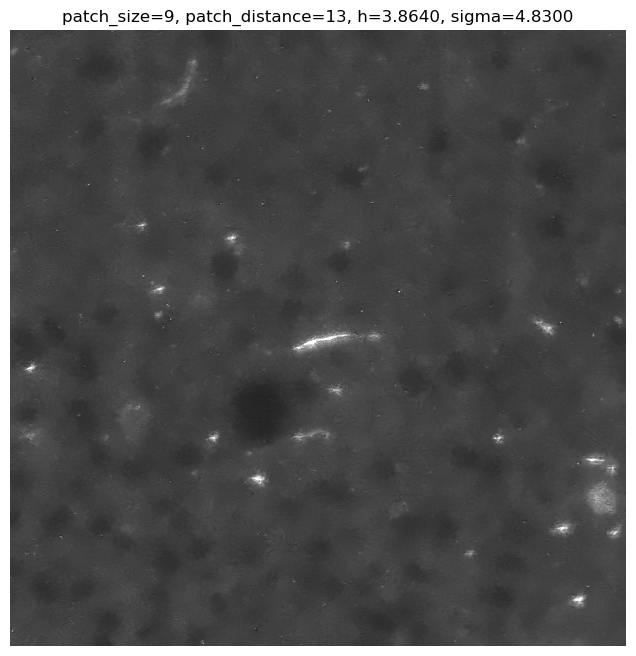

Compression ratio: 4.75698922779949


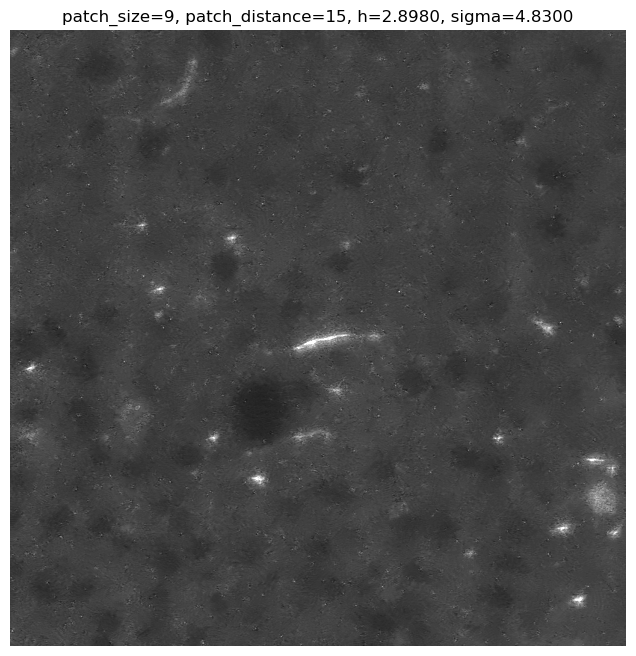

Compression ratio: 6.984546520302675


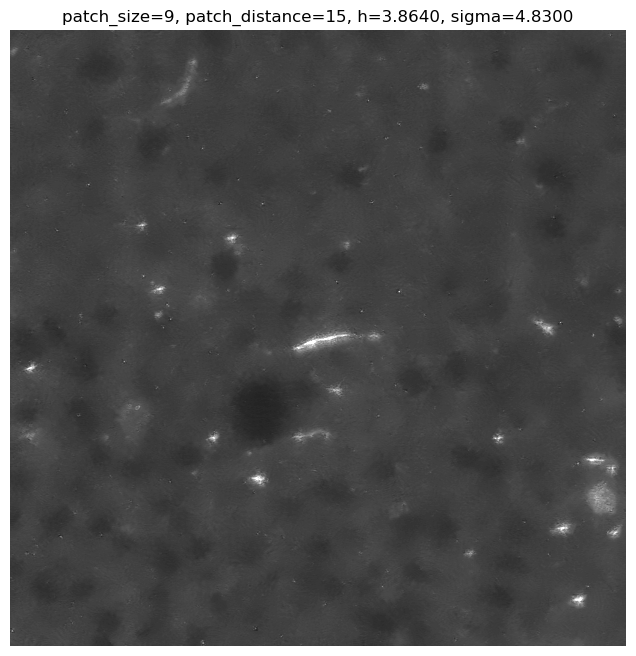

Compression ratio: 4.285832233171613


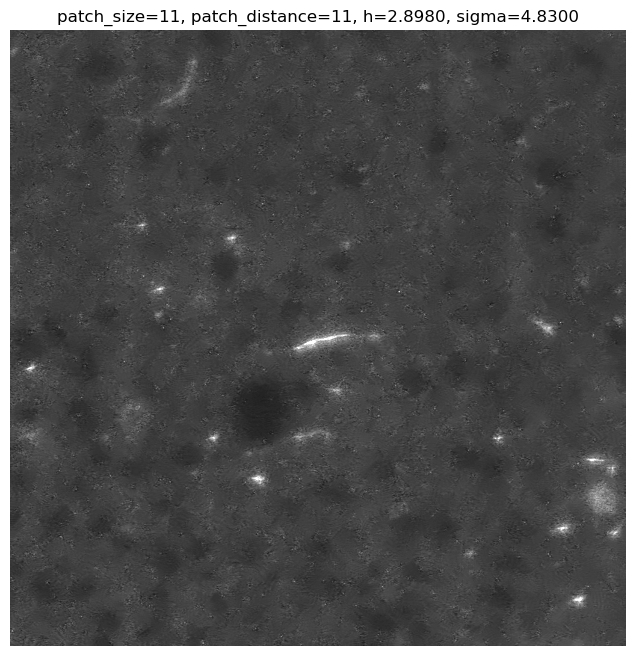

Compression ratio: 6.890366671047444


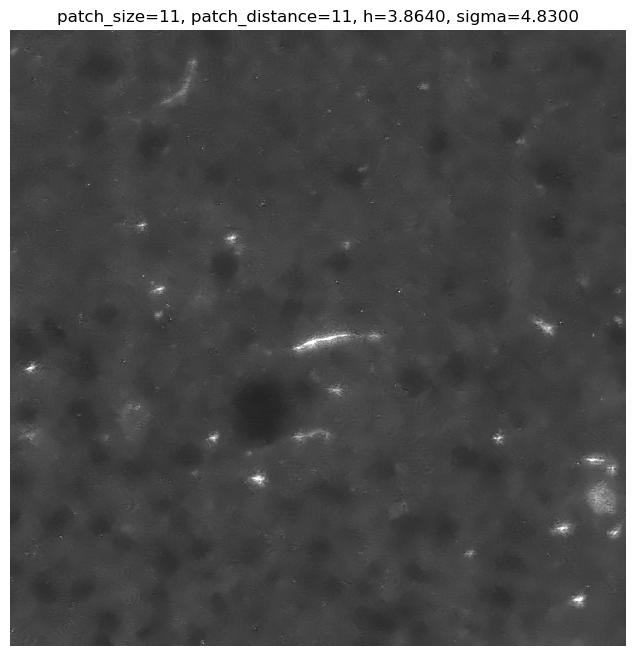

Compression ratio: 4.432310192729171


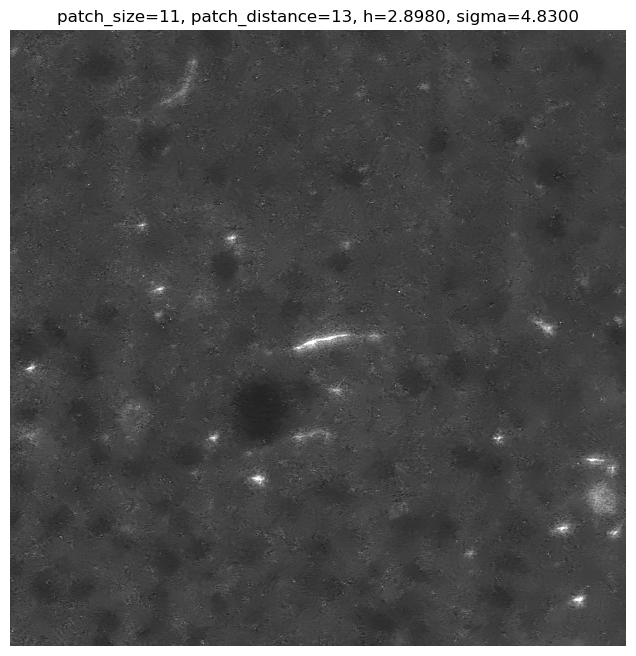

Compression ratio: 7.292539337564114


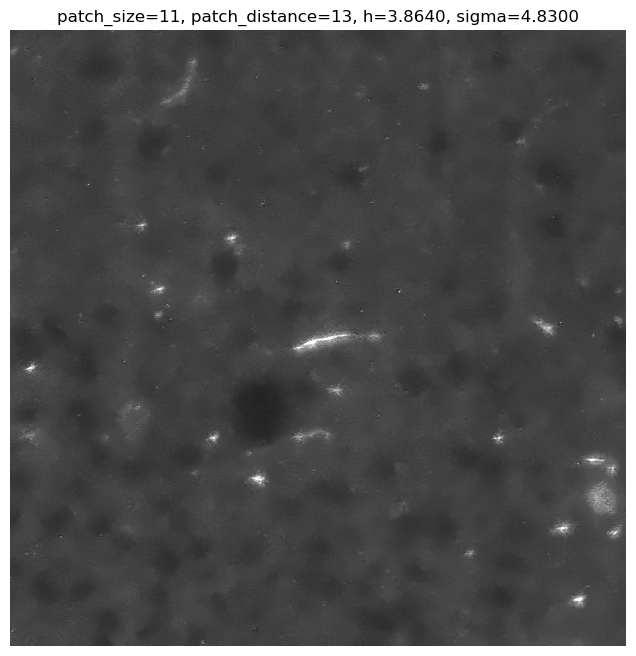

Compression ratio: 4.5845901603506505


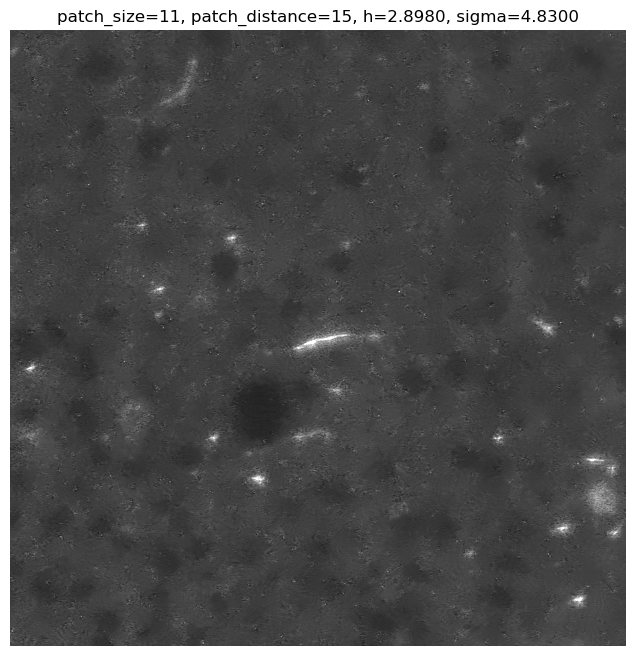

Compression ratio: 7.62317976605041


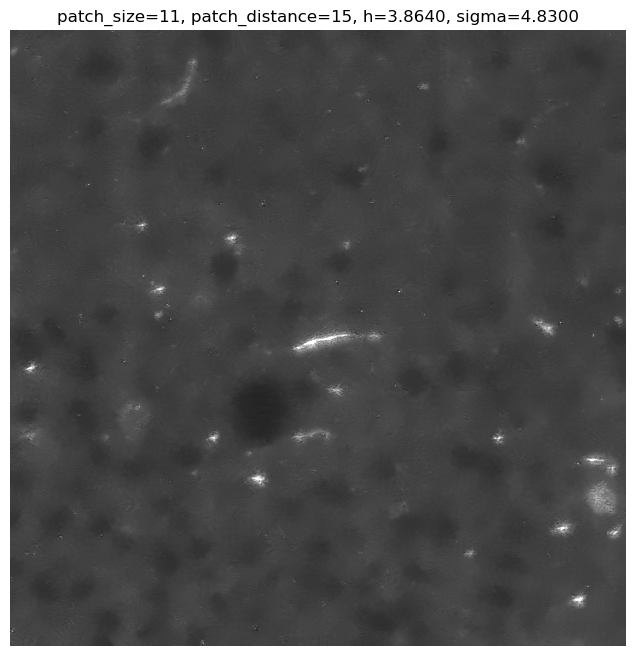

In [8]:
for param_set in params:
    patch_size, patch_dist, h, sig = param_set
    
    result = denoise_nl_means(
        s, 
        patch_size=patch_size, 
        patch_distance=patch_dist, 
        h=h, 
        sigma=sig, 
        fast_mode=True, 
        preserve_range=True, 
        channel_axis=None
    ).astype(np.uint16)
    
    encoded_bytes = len(codec.encode(result))
    print(f"Compression ratio: {s.nbytes / encoded_bytes}")
    
    plot_slice(result, title=f"patch_size={patch_size}, patch_distance={patch_dist}, h={h:.4f}, sigma={sig:.4f}")